In [2]:
%autosave 0

Autosave disabled


# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [14]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
model.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [15]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8041163946061036)

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [16]:
len(y_val)

1409

In [17]:
(y_val == churn_decision).mean()

np.float64(0.8041163946061036)

In [18]:
1132/ 1409

0.8034066713981547

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
accuracy_score(y_val, y_pred >= 0.5)

0.8041163946061036

In [21]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.605
0.15 0.661
0.20 0.703
0.25 0.736
0.30 0.757
0.35 0.764
0.40 0.781
0.45 0.792
0.50 0.804
0.55 0.803
0.60 0.797
0.65 0.789
0.70 0.765
0.75 0.742
0.80 0.730
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


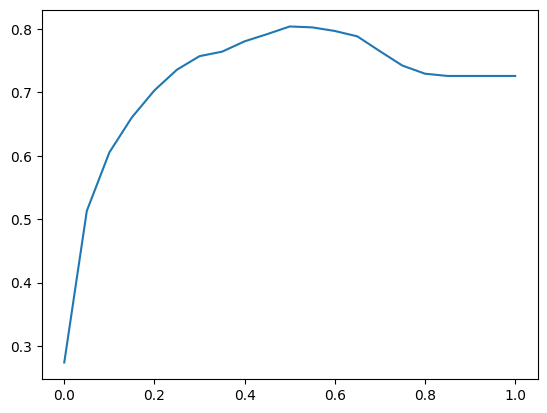

In [23]:
   plt.plot(thresholds, scores)

In [24]:
from collections import Counter

In [25]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [26]:
1 - y_val.mean()

np.float64(0.7260468417317246)

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

In [29]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [30]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [31]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [32]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[921, 102],
       [174, 212]])

In [33]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [36]:
p = tp / (tp + fp)
p

np.float64(0.6751592356687898)

In [37]:
r = tp / (tp + fn)
r

np.float64(0.5492227979274611)

## 4.5 ROC Curves

### TPR and FRP

In [38]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [33]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [39]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [42]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores[:10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,898,1,125,0.997409,0.877810
2,0.02,383,806,3,217,0.992228,0.787879
3,0.03,382,751,4,272,0.989637,0.734115
4,0.04,382,712,4,311,0.989637,0.695992
5,0.05,378,678,8,345,0.979275,0.662757
6,0.06,377,652,9,371,0.976684,0.637341
7,0.07,375,620,11,403,0.971503,0.606061
8,0.08,373,590,13,433,0.966321,0.576735
9,0.09,368,557,18,466,0.953368,0.544477


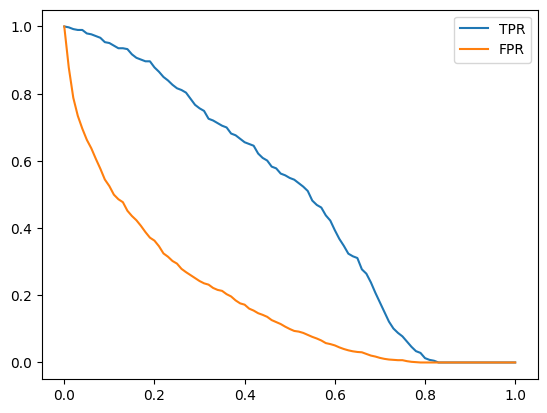

In [43]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [44]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [45]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [46]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [47]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

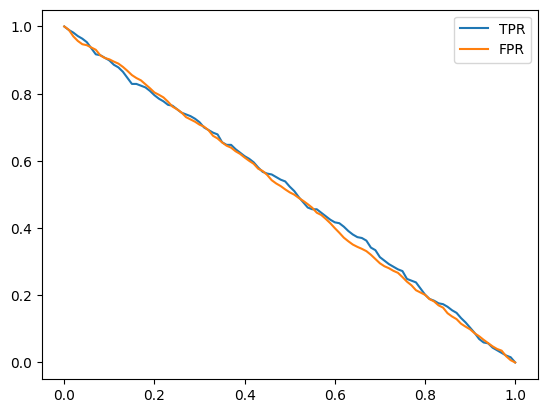

In [48]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [49]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [50]:

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [51]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [52]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [53]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


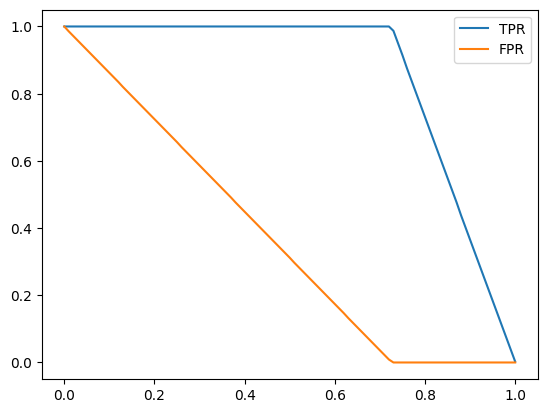

In [54]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

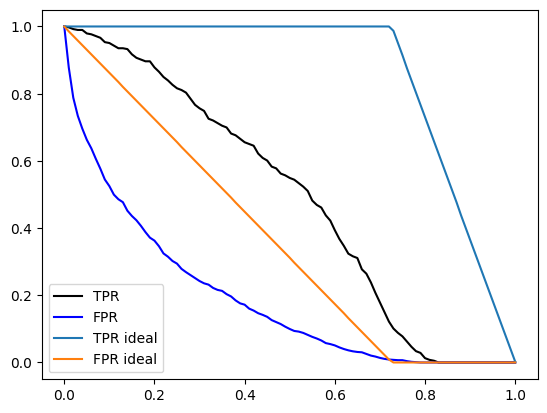

In [55]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

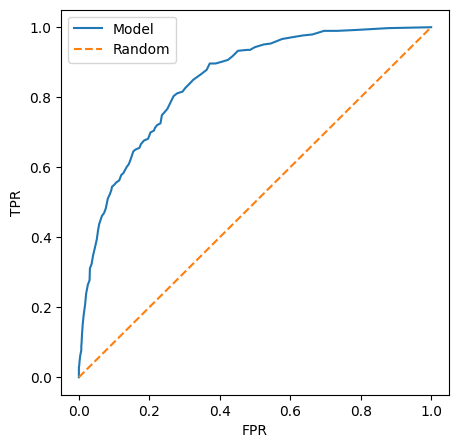

In [56]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [57]:
from sklearn.metrics import roc_curve

In [58]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

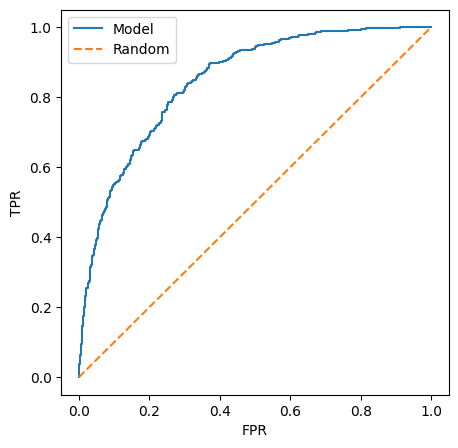

In [59]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [60]:
from sklearn.metrics import auc

In [61]:
auc(fpr, tpr)

0.8466311113812368

In [62]:
auc(df_scores.fpr, df_scores.tpr)

0.8463905307462051

In [63]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [64]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8466311113812368

In [65]:
from sklearn.metrics import roc_auc_score

In [66]:
roc_auc_score(y_val, y_pred)

0.8466311113812368

In [67]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [68]:
import random

In [69]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84627

In [70]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8491)

## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [79]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=C, max_iter=1000)
    )
    model.fit(X_train, y_train)

    return dv, model

In [80]:
dv, model = train(df_train, y_train, C=0.001)

In [81]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [82]:
y_pred = predict(df_val, dv, model)

In [83]:
from sklearn.model_selection import KFold

In [112]:
#!pip install tqdm

You should consider upgrading via the '/home/alexey/.pyenv/versions/3.8.11/bin/python3.8 -m pip install --upgrade pip' command.


In [84]:
from tqdm.auto import tqdm

In [85]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:01<00:06,  1.06s/it]

C=0.001 0.834 +- 0.010


 29%|██▊       | 2/7 [00:01<00:04,  1.07it/s]

C=0.01 0.838 +- 0.007


 43%|████▎     | 3/7 [00:02<00:03,  1.12it/s]

C=0.1 0.841 +- 0.007


 57%|█████▋    | 4/7 [00:03<00:02,  1.06it/s]

C=0.5 0.842 +- 0.007


 71%|███████▏  | 5/7 [00:04<00:01,  1.08it/s]

C=1 0.842 +- 0.007


 86%|████████▌ | 6/7 [00:05<00:00,  1.13it/s]

C=5 0.842 +- 0.007


100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

C=10 0.842 +- 0.007


In [86]:
scores

[0.8439921187525021,
 0.8446584061713681,
 0.833726670680313,
 0.8347649005563726,
 0.8520324119105144]

In [87]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8584546675766735

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week